# Using NumPy and SciPy modules

In addition to using Cantera and Pint to help solve thermodynamics problems, we will need to use some additional packages in the scientific Python ecosystem to make plots, solve systems of equations, integrate ordinary differential equations, and more.

:::{note}
The [*SciPy Lecture Notes*](https://scipy-lectures.org) are excellent, detailed resources on all these topics, and Python programming in general {cite:p}`scipylecture`.
:::

The examples contained in this electronic book will integrate these techniques as needed, but this notebook contains some specific examples.

## Index

1. [Plotting](#plotting)
2. [Solving systems of equations](#solving-systems-of-equations)
3. [Integrating ODE systems](#integrating-ode-systems)
4. [Optimization](#optimization)
5. [Differentiation](#differentiation)


(plotting)=
## Plotting

We can use [Matplotlib](https://matplotlib.org) to produce nice plots of our results. If you used Anaconda to set up your computing environment, you likely already have Matplotlib installed; if not, see their [installation instructions](https://matplotlib.org/users/installing.html).

Matplotlib provides an interface that is very similar to what you might already know from Matlab: `pyplot`. You can import this in Python files or a Jupyter notebook with the standard abbreviation `plt`:

In [1]:
# this line makes figures interactive in Jupyter notebooks
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# these lines are only for helping improve the display
#import matplotlib_inline.backend_inline
#matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi']= 300
plt.rcParams['savefig.dpi'] = 300

For example, let's generate some values of an independent variable $x$ linearly spaced between 0 and 10 (using the NumPy function [`linspace()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html)), and then plot the function $y(x) = \sin(x)$. We can also add labels to the axes, a legend, and a helpful grid.

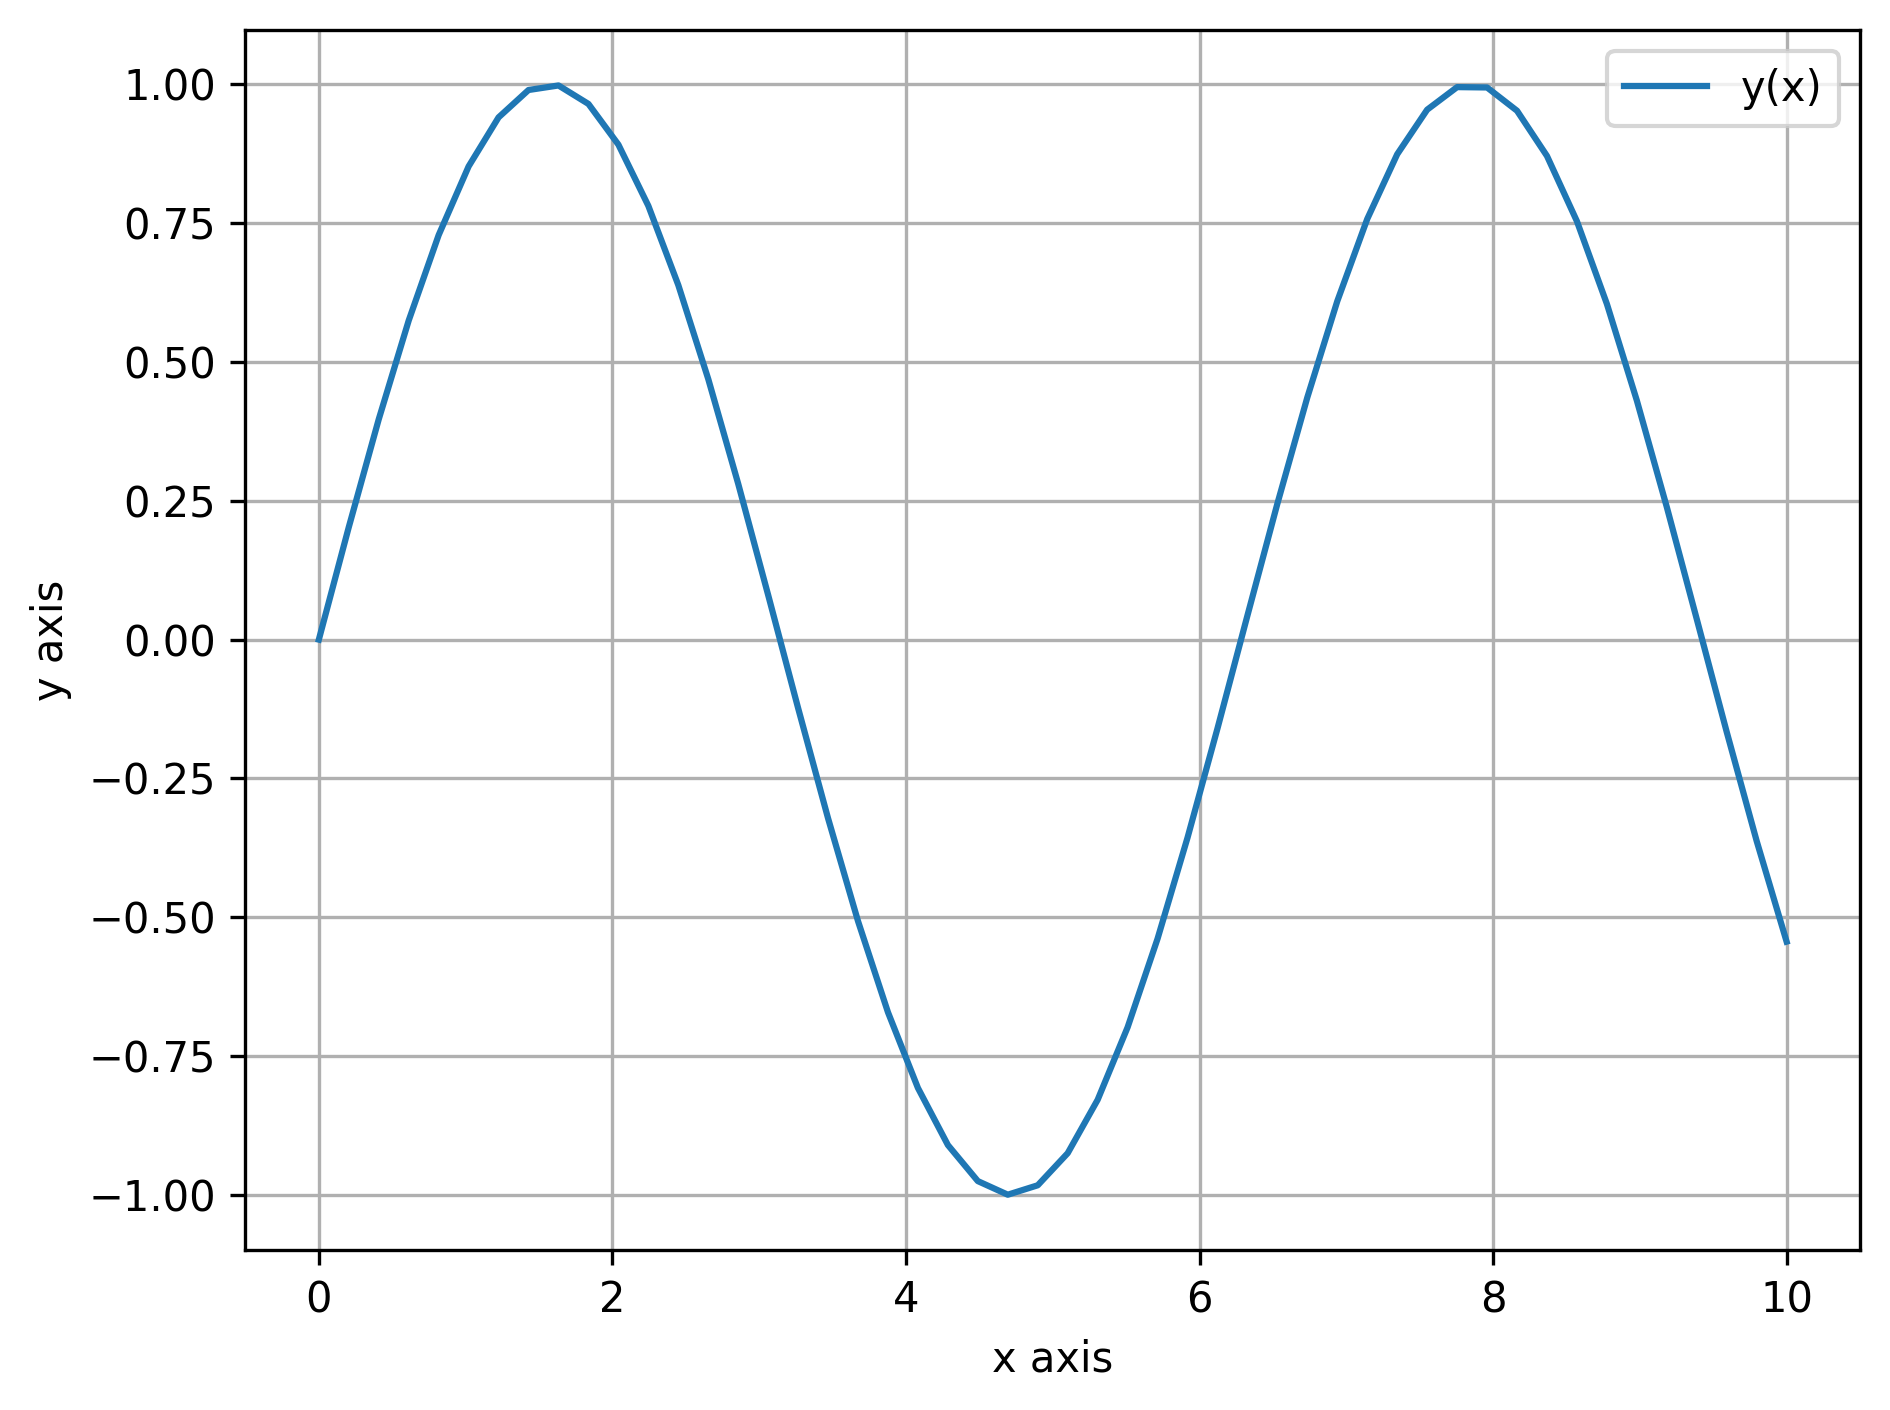

In [3]:
import numpy as np

x = np.linspace(0, 10, num=50, endpoint=True)
y = np.sin(x)

plt.plot(x, y, label='y(x)')
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We can also plot multiple data series in a single figure:

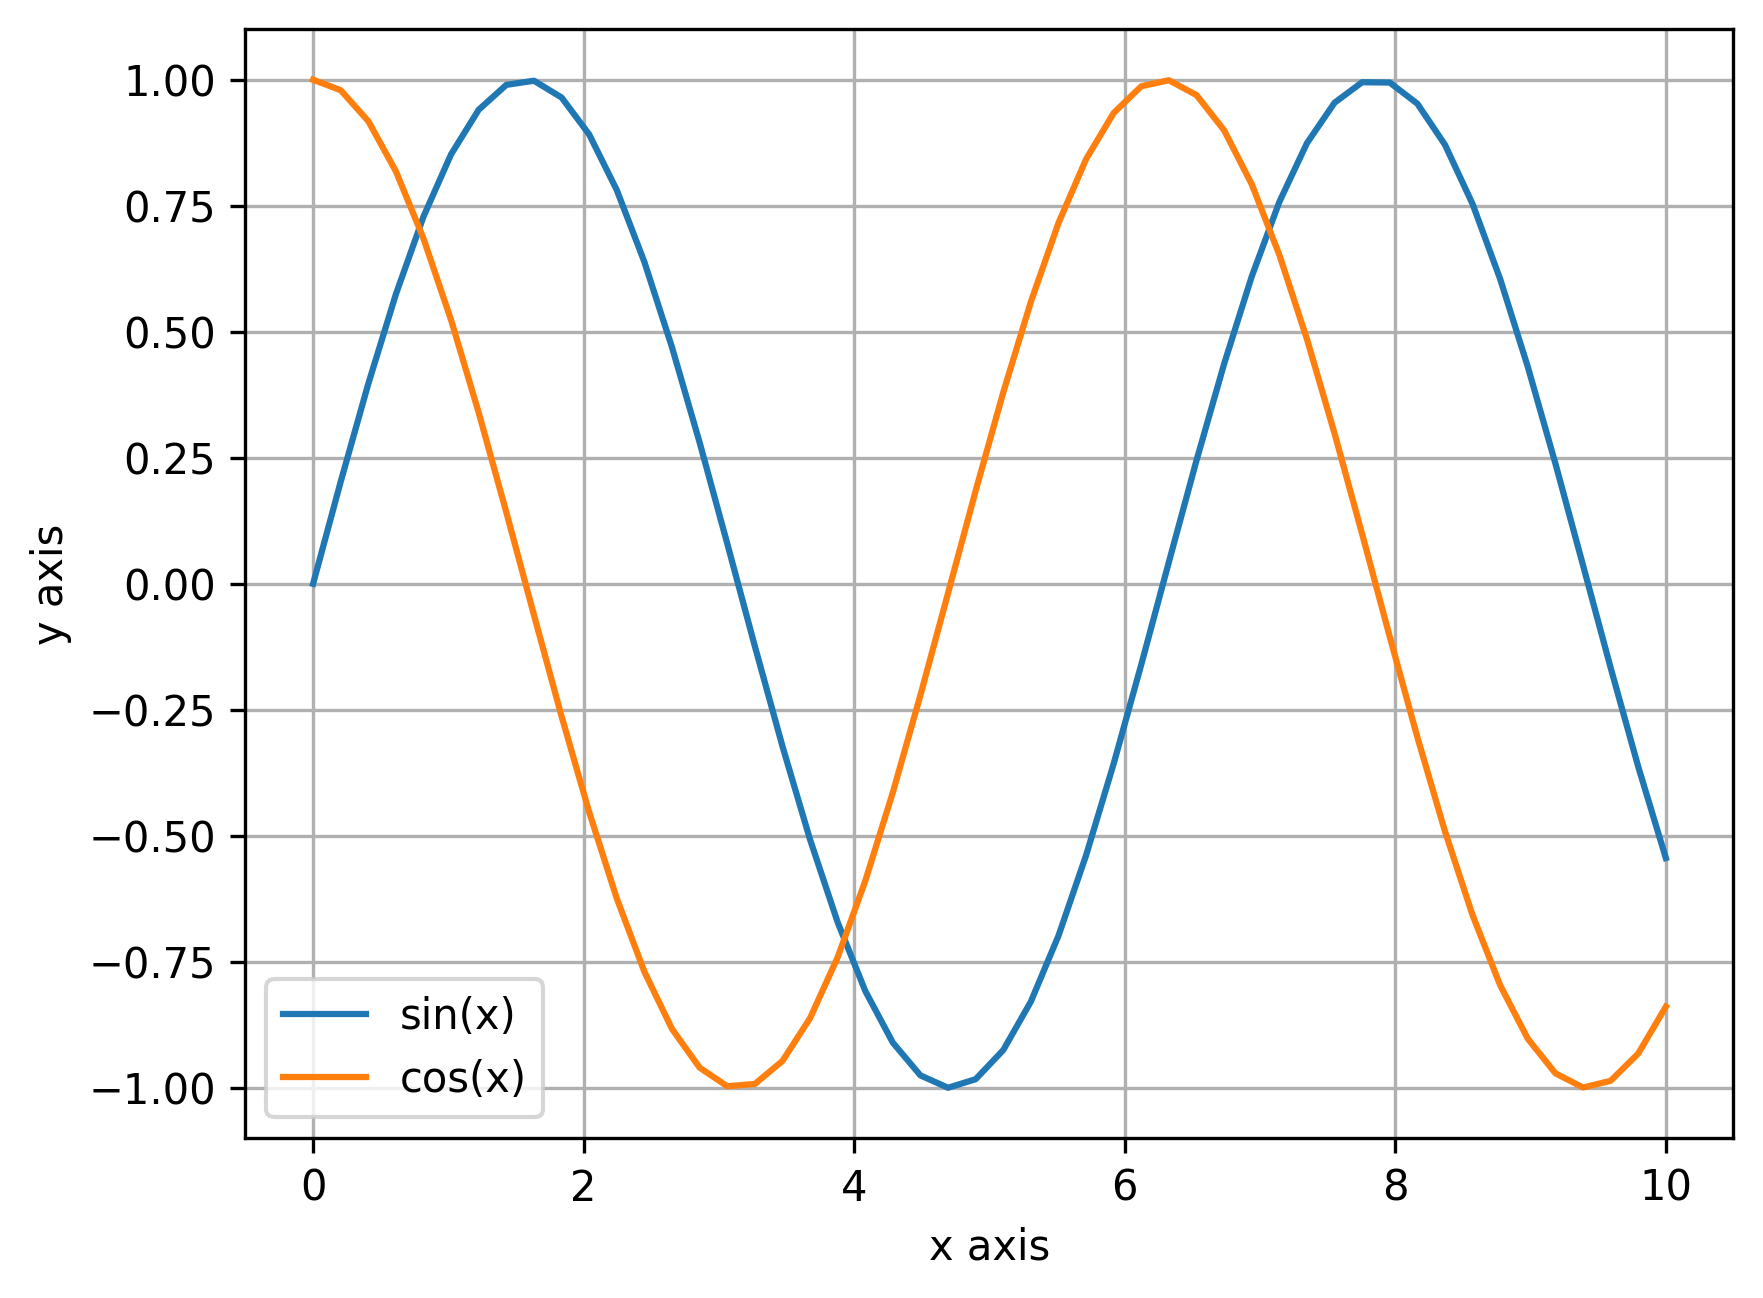

In [4]:
plt.plot(x, y, label='sin(x)')
plt.plot(x, np.cos(x), label='cos(x)')
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.grid(True)
plt.legend()
plt.show()

Or, we can use subplots to plot multiple axes in the same overall figure:

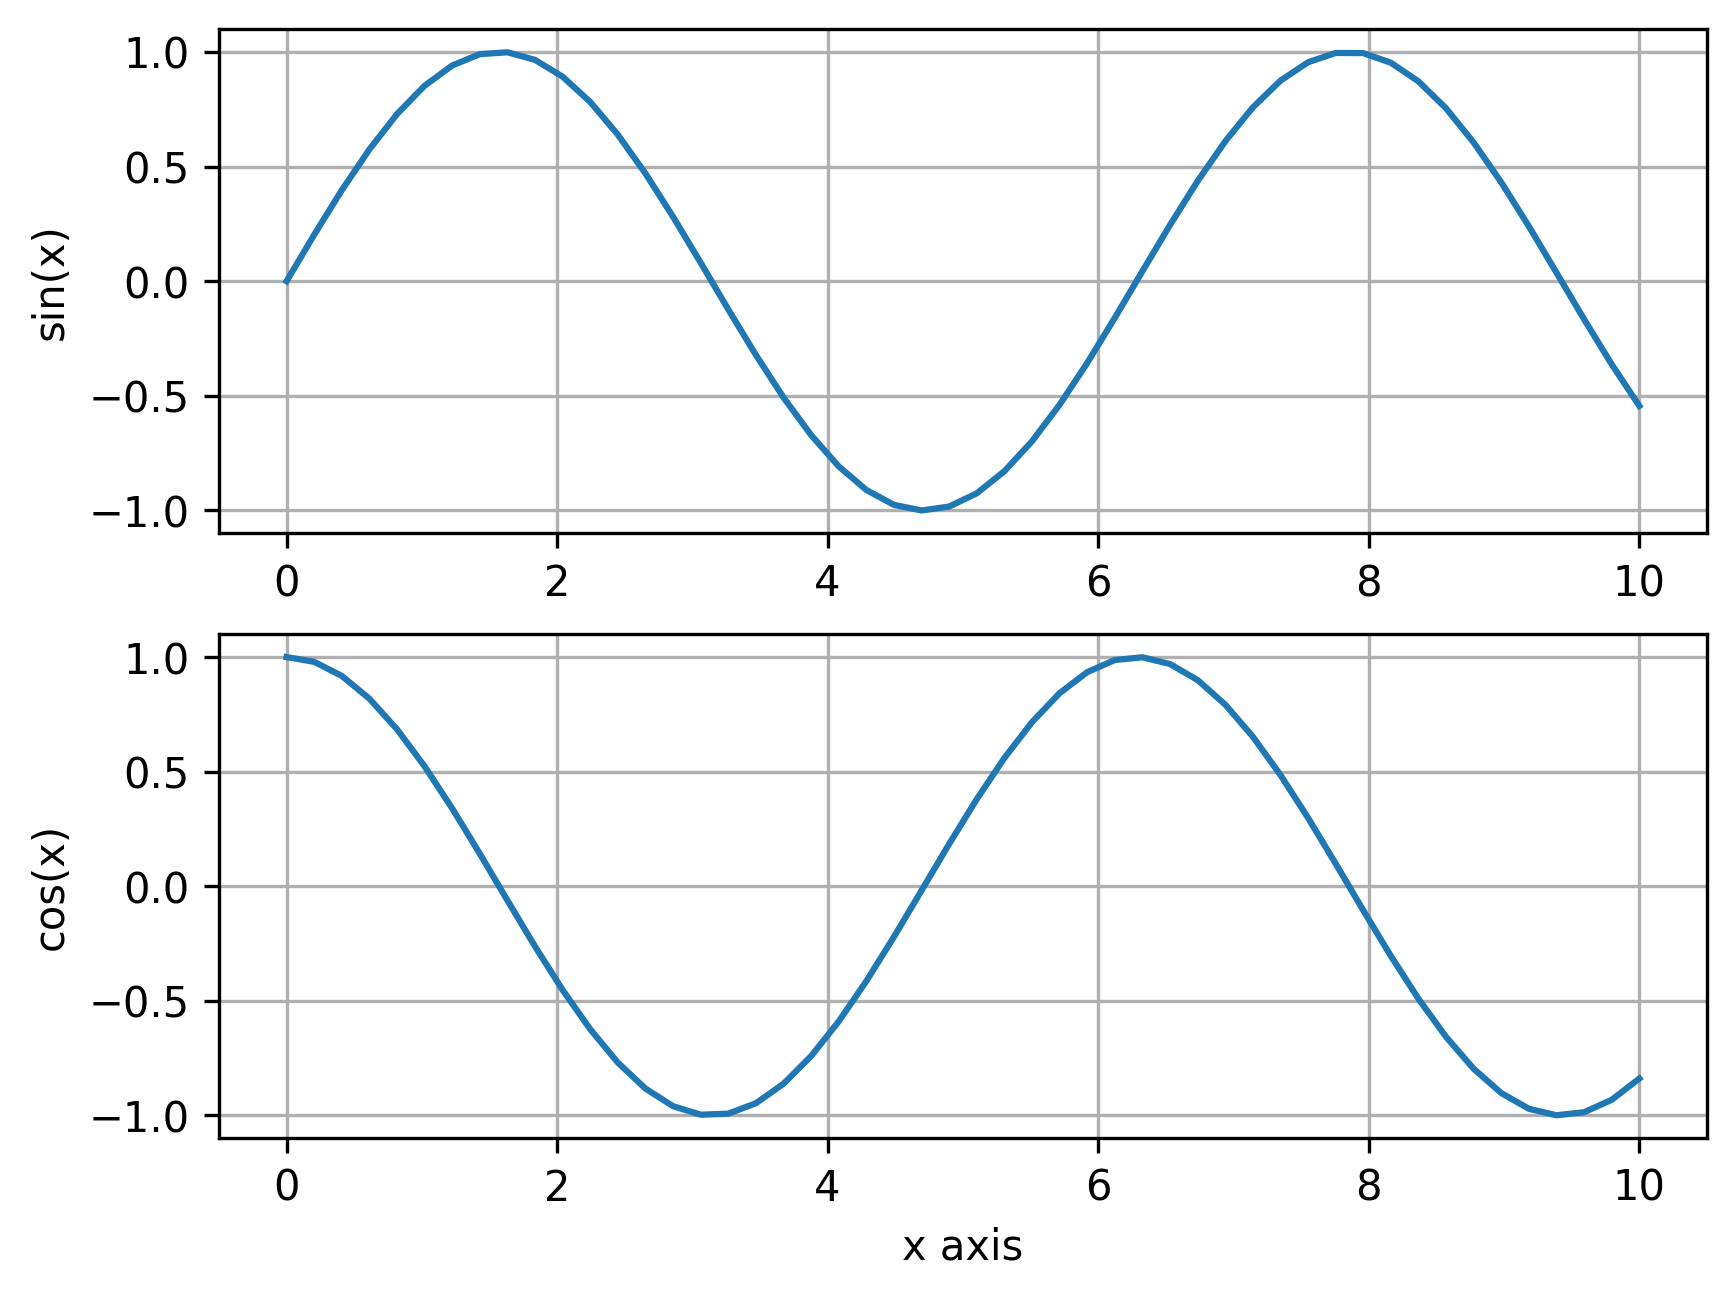

In [5]:
# 2 rows, 1 column
fig, axes = plt.subplots(2, 1)

axes[0].plot(x, y, label='sin(x)')
axes[0].set_ylabel('sin(x)')
axes[0].grid(True)

axes[1].plot(x, np.cos(x), label='cos(x)')
axes[1].set_xlabel('x axis')
axes[1].set_ylabel('cos(x)')
axes[1].grid(True)

plt.show()

(solving-systems-of-equations)=
## Solving systems of equations

Frequently we will encounter a system of one or more equations that involves an equal number of unknowns. If this is a linear system of equations, we can use linear algebra and the NumPy [`linalg.solve()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html) function, but more often in thermodynamics we encounter complex and/or nonlinear systems.

In cases like this, we will need to set up our problems to find the roots, or zeroes, of the function(s); in other words, given a function $ f(x) $, finding the root means to find the value of $x$ such that $ f(x) = 0 $. If we are dealing with a system of equations and the same number of unknowns, then these would be vectors: $\mathbf{f}(\mathbf{x}) = 0$.

(You might be wondering what to do about equations that don't equal zero... for example, if you have something like $f(x) = g(x)$. In this case, you just need to manipulate the equation to be in the form $f(x) - g(x) = 0$.)

The [SciPy optimization module](https://docs.scipy.org/doc/scipy/reference/optimize.html) provides functions to find roots of equations; for scalar equations, we can use [`root_scalar()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html#scipy.optimize.root_scalar), and for vector equations, we can use [`root()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html).

### Scalar equations 

Let's first look at an example of a scalar function: one equation, one unknown.

Find the root of this equation:
$$
\cos(x) = x^3
$$

We need to create a Python function that returns $f(x) = 0$, so that the function returns zero when the input value of $x$ is the (correct) root. Then, we can use the `root_scalar` function with some initial guesses.

In [6]:
import numpy as np
from scipy import optimize

def func(x):
    return np.cos(x) - x**3

sol = optimize.root_scalar(func, x0=1.0, x1=2.0)

print(f'Root: x ={sol.root: .3f}')

print(f'Function evaluated at root: {func(sol.root)}')

Root: x = 0.865
Function evaluated at root: 1.1102230246251565e-16


### Systems of equations / vector functions

We can also solve systems of equations in a similar fashion using the SciPy [`root()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html) functino, where we find the roots $\mathbf{x}$ that satisfy $\mathbf{f} (\mathbf{x}) = 0$.

For example, let's try to find the values of $x$ and $y$ that satisfy these equations:
$$
x \ln (x) = y^3 \\
\sqrt{x} = \frac{1}{y}
$$

We have two equations and two unknowns, so we should be able to find the roots.

To solve, we create a function that evaluates these equations when made equal to zero, or

$$
x \ln (x) - y^3 = 0 \\
\sqrt{x} - \frac{1}{y} = 0
$$

then we call `root` specifying this function and two initial guesses for $x$ and $y$:

In [7]:
import numpy as np
from scipy import optimize

def system(vars):
    x = vars[0]
    y = vars[1]
    
    return [
        x*np.log(x) - y**3,
        np.sqrt(x) - (1/y)
        ]

sol = optimize.root(system, [1.0, 1.0])

x = sol.x[0]
y = sol.x[1]

print(f'Roots: x = {x: .3f}, y = {y: .3f}')

Roots: x =  1.467, y =  0.826


(integrating-ode-systems)=
## Integrating ODE systems

In some cases, we encounter problems that require integrating one or more ordinary different equations in time. Depending on the form of the problem, we may need to integrate a function between two points (definite integral), or we may have a system of ordinary differential equations.

### Numerical integral of samples

In some cases we have a set of $(x,y)$ data that we want to integrate numerically.
We can do this using the NumPy [`trapz()` function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.trapz.html), which implements the composite trapezoidal rule.

For example, let's consider a situation where a reciprocating compressor is being used to compress ammonia vapor during a refrigeration cycle. We have some experimental measurements of the pressure-volume data during the compression stroke (see table), and we want to determine the work done on the ammonia by the piston.

| Pressure (psi) | Volume (in^3) |
|----------------|---------------|
| 65.1           | 80.0          |
| 80.5           | 67.2          |
| 93.2           | 60.1          |
| 110            | 52.5          |
| 134            | 44.8          |
| 161            | 37.6          |
| 190            | 32.5          |

To find the work done by the piston to the ammonia, we can integrate pressure with respect to volume:
$$
W_{\text{in}} = -\int_{V_1}^{V_2} P \, dV
$$

In [9]:
import numpy as np
from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity

pressure = Q_([65.1, 80.5, 93.2, 110, 134, 161, 190], 'psi')
volume = Q_([80.0, 67.2, 60.1, 52.5, 44.8, 37.6, 32.5], 'in^3')

# convert to SI units
pressure.ito('Pa')
volume.ito('m^3')

work = -Q_(
    np.trapezoid(pressure.magnitude, volume.magnitude), 
    pressure.units * volume.units
    )
print(f'Work done on fluid: {work.to("J"): .2f}')

Work done on fluid:  589.45 joule


### Numerical integral of expression

We can also numerically integrate expressions/functions using the SciPy [`quad()` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html), also in the `integrate` module.

Let's build on the previous example: first, let's fit the compressor data to the polytropic form $P V^n = c$, where $c$ and $n$ are constants, then we can integrate the resulting function to calculate work.

To fit the data, we need to rearrange the equation to the form $y = f(x)$:
\begin{equation}
P = c V^{-n}
\end{equation}
We'll use the [`scipy.optimize.curve_fit()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) function for that.

In [11]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import quad

from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity

pressure = Q_([65.1, 80.5, 93.2, 110, 134, 161, 190], 'psi')
volume = Q_([80.0, 67.2, 60.1, 52.5, 44.8, 37.6, 32.5], 'in^3')

# convert to SI units
pressure.ito('Pa')
volume.ito('m^3')

def fit(V, n, c):
    '''Evaluate P = c * V**(-n). 
    
    n and c will be found by the curve_fit functino.
    '''
    return c * np.power(V, -n)

# this function will automatically fit the unknown constants
params, cov = curve_fit(fit, volume.magnitude, pressure.magnitude, p0=[1, 100])

print(f'Parameters: n={params[0]: 5.3f}, c={params[1]: 5.3f}')

Parameters: n= 1.170, c= 194.200


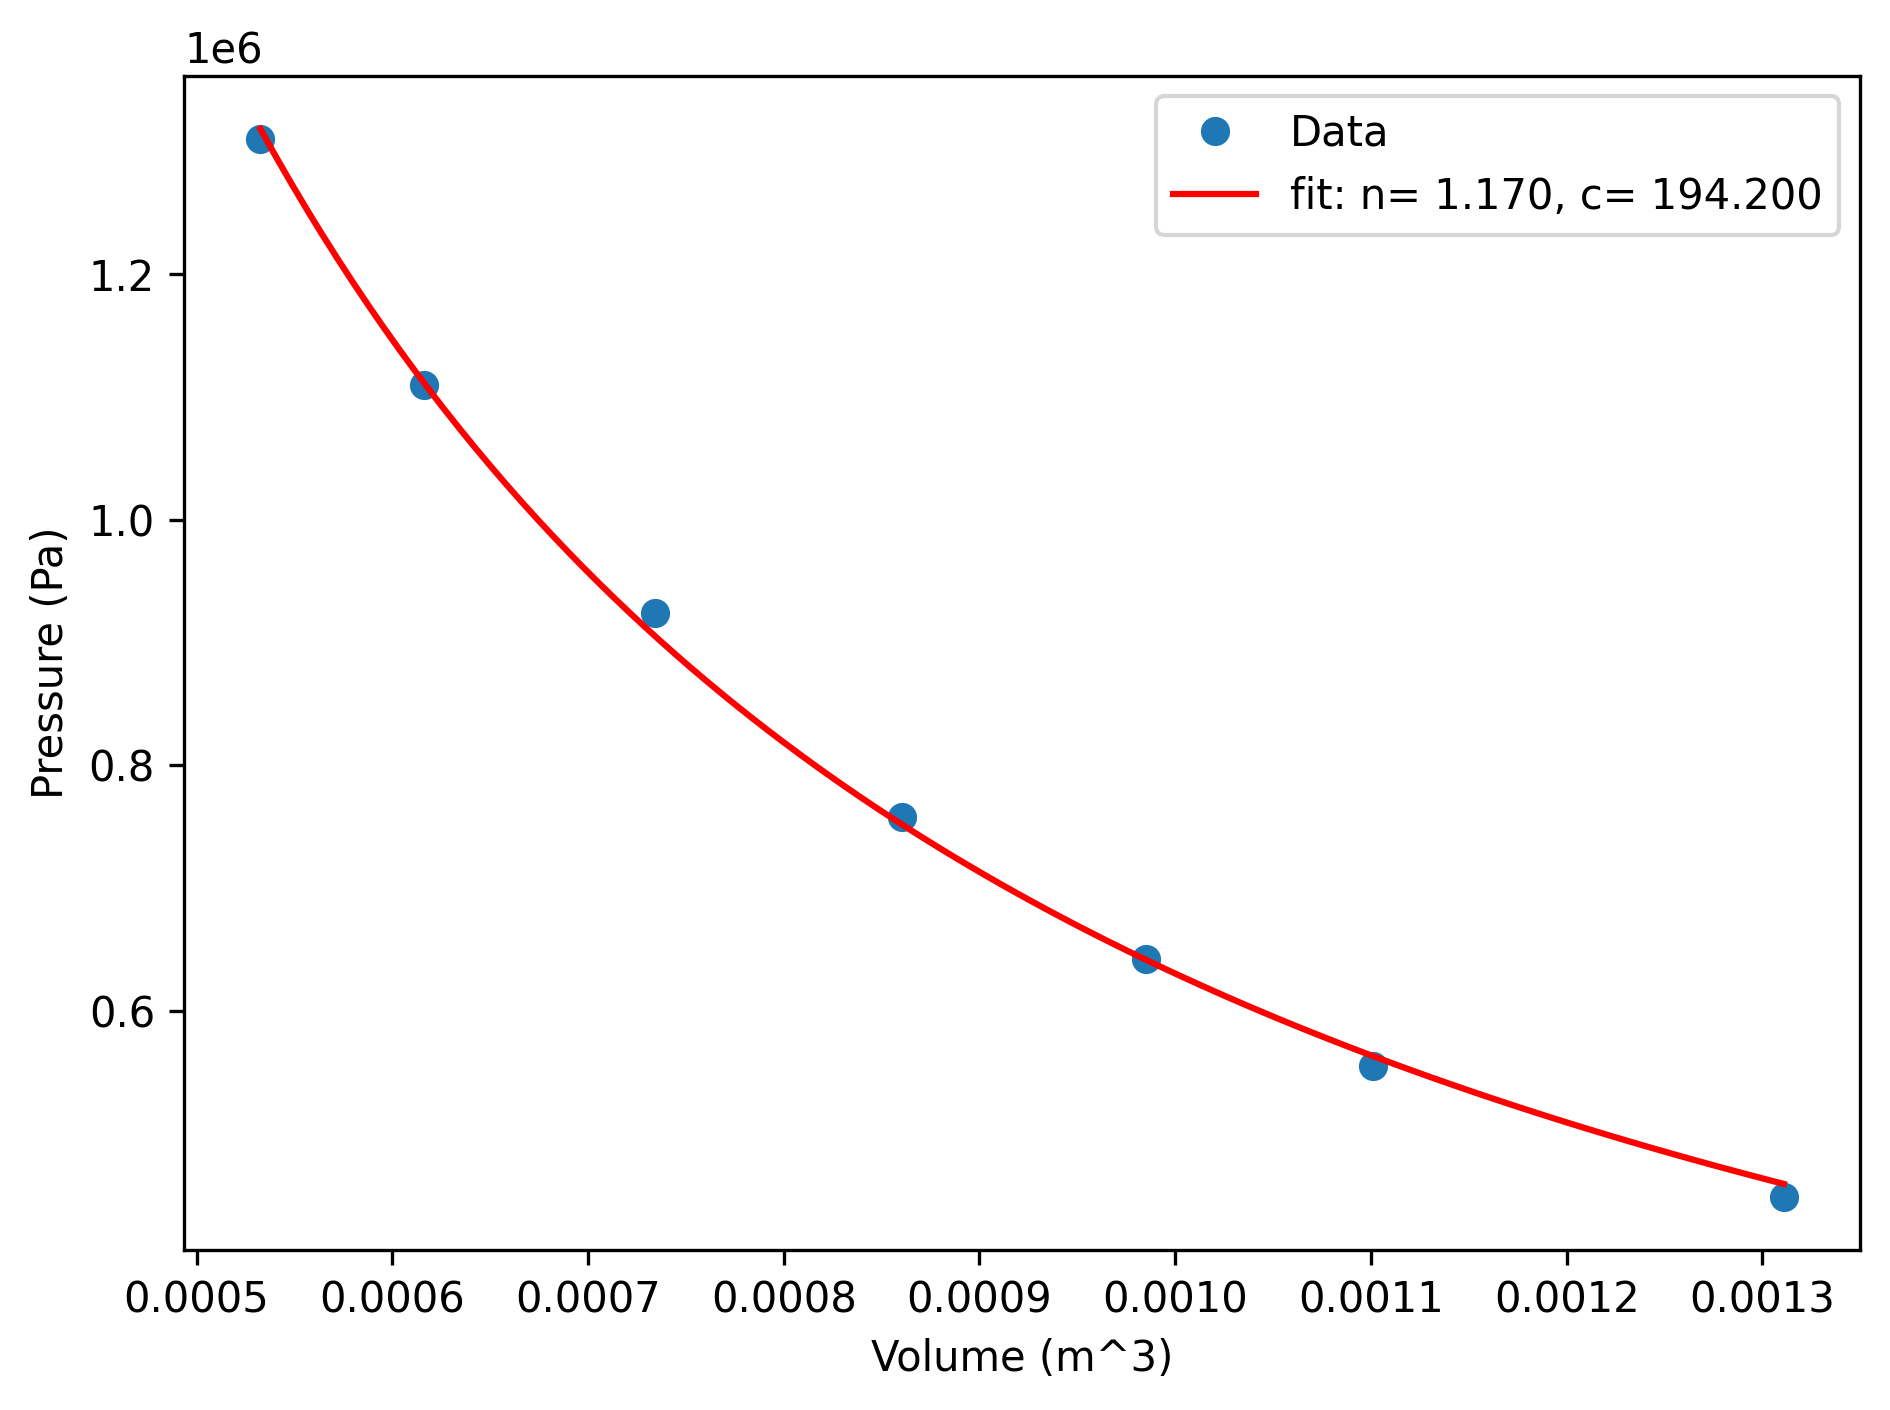

In [12]:
plt.plot(volume.magnitude, pressure.magnitude, 'o', label='Data')

x = np.linspace(volume[0].magnitude, volume[-1].magnitude, 100)

# plot data and fit
plt.plot(x, fit(x, *params), 'r-',
         label=f'fit: n={params[0]: 5.3f}, c={params[1]: 5.3f}'
         )
plt.xlabel('Volume (m^3)')
plt.ylabel('Pressure (Pa)')
plt.legend()
plt.tight_layout()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

That looks like a great fit to the data, so now let's evaluate the work by integrating:

In [13]:
y, err = quad(
    fit, volume[0].magnitude, volume[-1].magnitude, 
    args=(params[0], params[1])
    )

work = -Q_(y, pressure.units * volume.units)

print(f'Work done on fluid: {work.to("J"): .2f}')

Work done on fluid:  586.26 joule


### Initial value problems

In other words, we may have a system like
\begin{equation}
\frac{d \mathbf{y}}{dt} = \mathbf{f} (t, \mathbf{y})
\end{equation}
where $\mathbf{y}$ is the vector of state variables, for which we should have the initial values ($\mathbf{y}(t=0)$). In this case, we can use the SciPy function [`solve_ivp()` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html), part of the `integrate` module.

For example, let's consider a problem where we want to find the volume of water, volume of air, and pressure in a tank as a function of time, as the tank releases water to an environment. The volumetric flow rate through the tank's valve is based on its instantaneous pressure:

$$
\dot{V}_f = \frac{P - P_{\text{atm}}}{R_v} \;,
$$

where $P_{\text{atm}}$ is atmospheric pressure and $R_v = 10$ psi/gpm is the valve resistance parameter. The tank has volume 50 gal, and is initially filled with water (volume fraction $f$ = 0.8); the air in the tank is initially at 100 psi. We will treat the air as an ideal gas, and the water as an incompressible substance.

We have the initial air pressure, and we can calculate the initial volumes of water and air:

$$
V_{f,0} = f \, V \\
V_{g,0} = (1 - f) V \\
$$

We can perform a mass balance on the water in the tank to obtain a rate equation for the volume of water:

$$
0 = \dot{m}_f + \frac{d m_f}{dt} = \dot{V}_f \rho_f + \rho_f \frac{d V_f}{dt} \\
0 = \dot{V}_f + \frac{dV_f}{dt} \\
\therefore \frac{dV_f}{dt} = -\frac{(P - P_{\text{atm}})}{R_v}
$$

Since the overall volume of the tank is constant, we can obtain the rate of change of the volume of air:

$$
V = V_g + V_f \\
\frac{dV_g}{dt} + \frac{dV_f}{dt} = 0 \\
\therefore \frac{dV_g}{dt} = -\frac{dV_f}{dt}
$$

Finally, a mass balance on the air in the tank allows us to find the rate of change of pressure:

$$
0 = \frac{dm_a}{dt} \\
0 = \frac{d}{dt} \left( \frac{P V_g}{R T} \right) \\
0 = V_g \frac{dP}{dt} + P \frac{dV_g}{dt} \\
\therefore \frac{dP}{dt} = -\frac{P}{V_g} \frac{dV_g}{dt}
$$

Now, we can integrate this system of ODEs:

In [14]:
from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity

# initial conditions and constants
valve_resistance = Q_(10, 'psi/(gal/min)')
pressure_atmosphere = Q_(1, 'atm')

volume_tank = Q_(50, 'gal')
water_fraction = 0.8

pressure_initial = Q_(100, 'psi')
volume_water_initial = water_fraction * volume_tank
volume_air_initial = (1.0 - water_fraction) * volume_tank

In [15]:
def tank_equations(t, y, valve_resistance, pressure_atmosphere):
    '''Rates of change for water volume, air volume, and air pressure in tank.
    
    Input values in SI units.
    '''
    volume_water = Q_(y[0], 'm^3')
    volume_air = Q_(y[1], 'm^3')
    pressure_air = Q_(y[2], 'Pa')
    
    dVf_dt = -(pressure_air - pressure_atmosphere) / valve_resistance
    dVg_dt = -dVf_dt
    dP_dt = -(pressure_air / volume_air) * dVg_dt
    
    return [
        dVf_dt.to('m^3/s').magnitude, 
        dVg_dt.to('m^3/s').magnitude,
        dP_dt.to('Pa/s').magnitude
        ]

Now that we have the initial conditions and rate function set up, we can integrate in time. Let's do this for 500 seconds, and then plot the water volume and tank pressure as functions of time:

In [16]:
from scipy.integrate import solve_ivp

# now integrate for 500 seconds, specifying the function, time interval, 
#initial conditions, and additional arguments to the function

sol = solve_ivp(
    tank_equations, [0, 500.0],
    [volume_water_initial.to('m^3').magnitude, 
     volume_air_initial.to('m^3').magnitude, 
     pressure_initial.to('Pa').magnitude
     ],
    args=(valve_resistance, pressure_atmosphere,),
    method='BDF'
    )

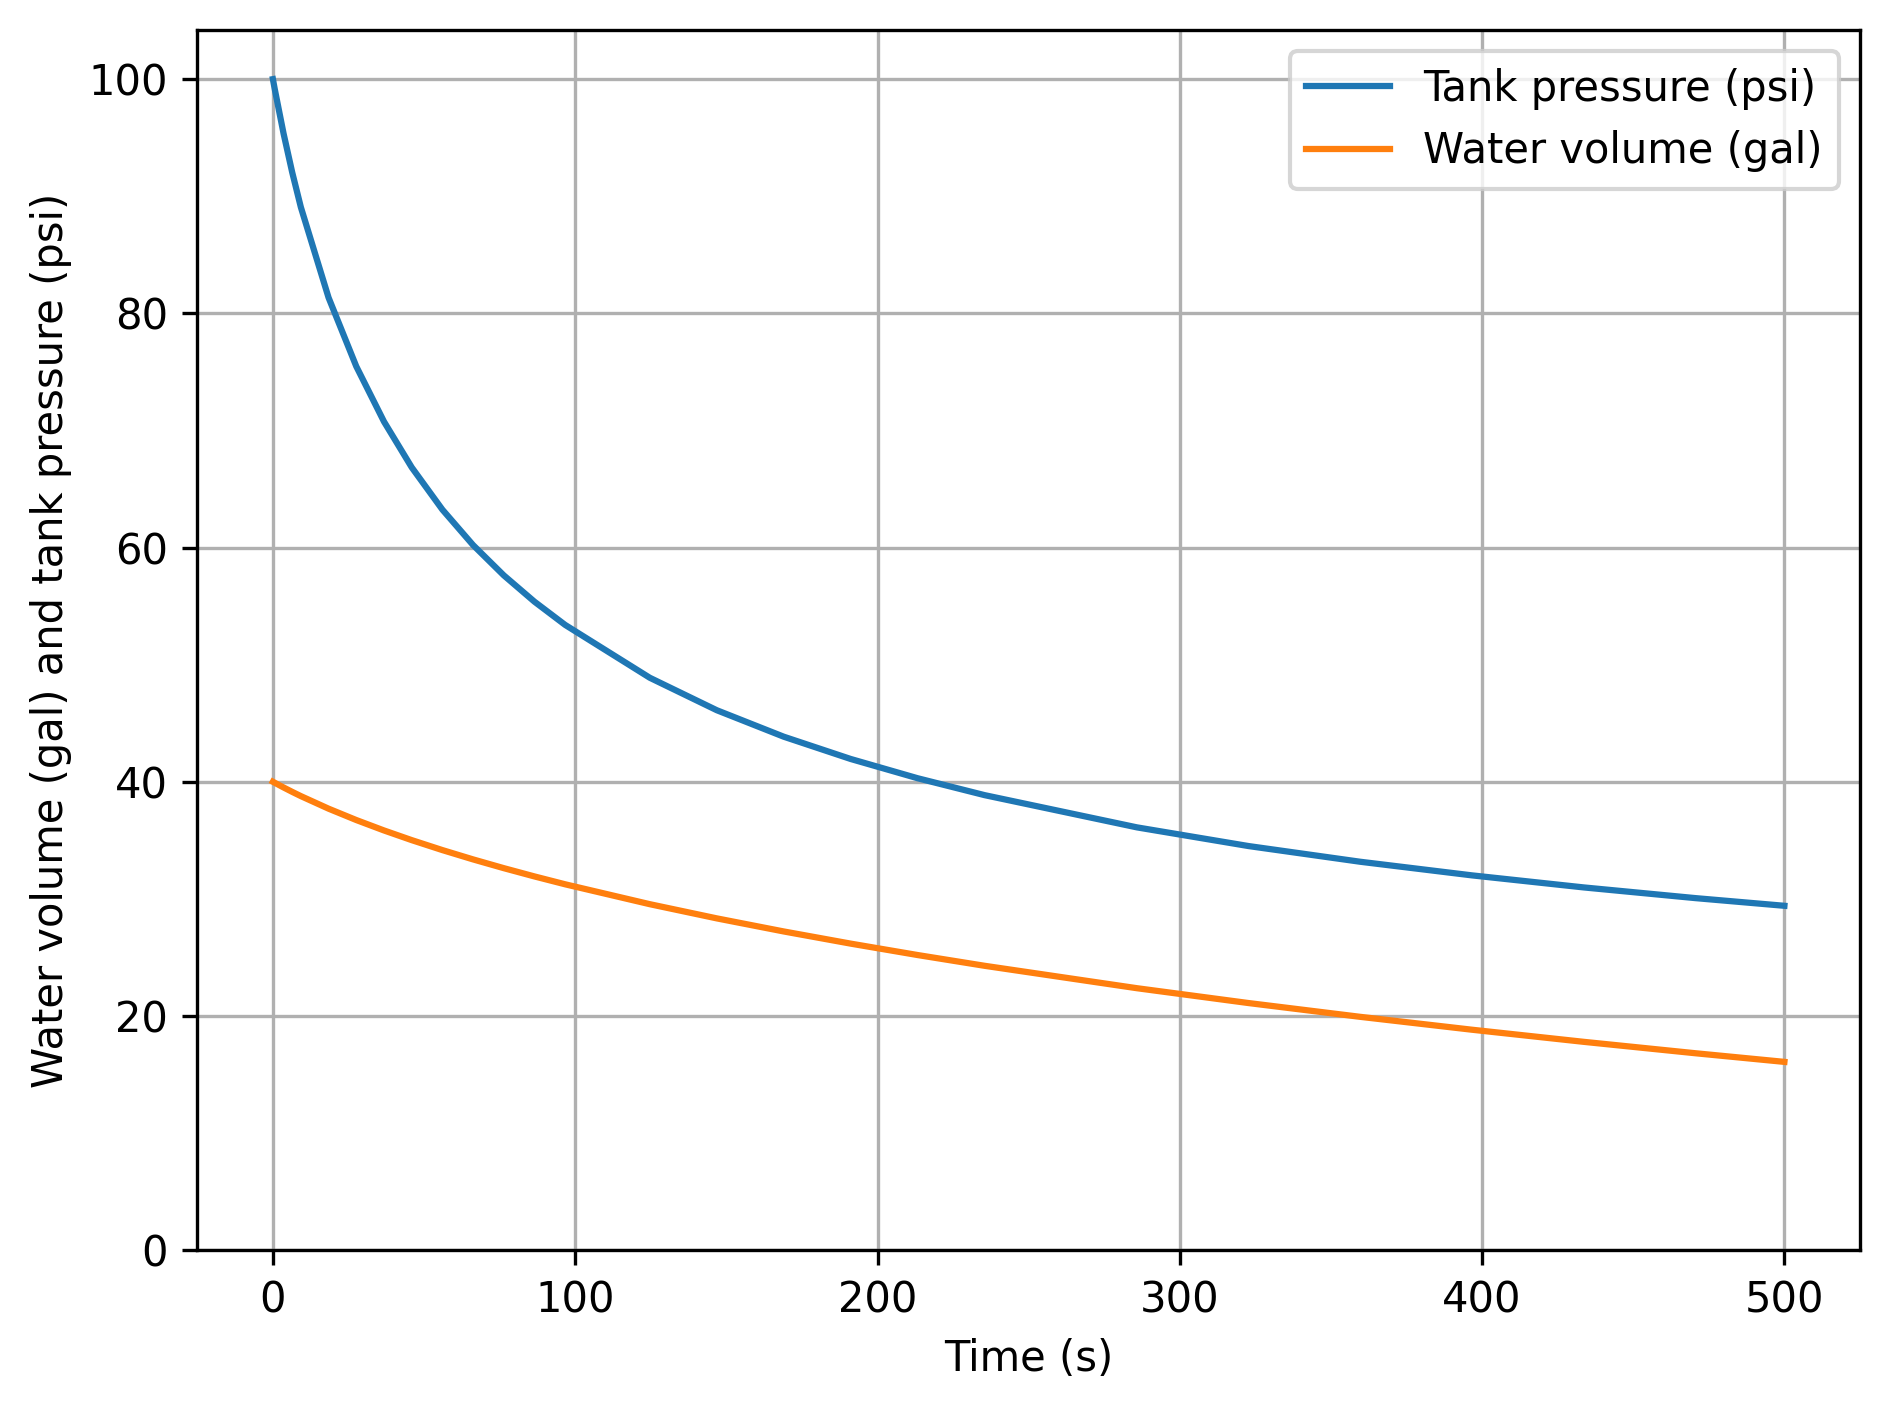

In [17]:
time = sol.t
volume_water = Q_(sol.y[0], 'm^3')
volume_air = Q_(sol.y[1], 'm^3')
pressure = Q_(sol.y[2], 'Pa')

plt.plot(time, pressure.to('psi').magnitude, label='Tank pressure (psi)')
plt.plot(time, volume_water.to('gal').magnitude, label='Water volume (gal)')
plt.grid(True)
plt.xlabel('Time (s)')
plt.ylabel('Water volume (gal) and tank pressure (psi)')
plt.ylim(ymin=0.0) # ensure lower y-axis bound is zero
plt.legend()
plt.tight_layout()
plt.show()

(optimization)=
## Optimization

For some problems, we may want to find the input parameter(s) that minimize or maximize some function. In these cases, we can use the SciPy [`minimize_scalar()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html) function for a scalar function with one input variable, or the [`minimize()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function for a scalar function of one or more input variables.

(Note: this is a fairly complicated topic, and we will only consider relatively simple optimization problems.)

For example, consider a spring with a horizontal force applied; we can calculate the potential energy of the spring:
\begin{equation}
PE(x) = 0.5 k x^2 - F x \;.
\end{equation}
At equilibrium, the potential energy will be at a minimum, so given a particular force we can find the displacement by finding the value that minimizes the potential energy.

In [18]:
from scipy.optimize import minimize_scalar

spring_constant = 2.0 # N/cm
force = 5.0 # N

def spring(x, k, F):
    '''Calculates potential energy of spring pulled by force.
    '''
    return 0.5 * k * x**2 - F * x


sol = minimize_scalar(spring, args=(spring_constant, force))

print(f'Equilibrium displacement: {sol.x: .2f} cm')

Equilibrium displacement:  2.50 cm


A more complicated problem is a system with two springs, connected at one end with a force in some general direction (with $x$ and $y$ components); the system has both horizontal and vertical components. The springs have spring constants $k_a$ and $k_b$, and unloaded lengths $L_a$ and $L_b$.

The potential energy for this system is
\begin{equation}
PE(x,y) = 0.5 k_a \left( \sqrt{x^2 + (L_a - y)^2} - L_a \right)^2 + 0.5 k_b \left( \sqrt{x^2 + (L_b + y)^2} - L_b \right)^2 - F_x x - F_y y
\end{equation}
where $x$ and $y$ are the horizontal and vertical deformations from the unloaded state.
We can minimize this function of two variables to find the displacement based on the force:

In [19]:
from scipy.optimize import minimize

spring_constant_a = 9.0 # N/cm
spring_constant_b = 2.0 # N/cm
length_a = 10.0 # cm
length_b = 10.0 # cm

force_x = 2.0 # N
force_y = 4.0 # N

def spring_system(xvec, ka, kb, La, Lb, Fx, Fy):
    '''Calculates potential energy of springs pulled by force.
    '''
    x = xvec[0]
    y = xvec[1]
    return (
        0.5*ka * (np.sqrt(x**2 + (La - y)**2) - La)**2 +
        0.5*kb * (np.sqrt(x**2 + (Lb + y)**2) - Lb)**2
        - (Fx * x) - (Fy * y)
        )

guesses = [1.0, 1.0]
sol = minimize(
    spring_system, guesses, 
    args=(spring_constant_a, spring_constant_b, 
          length_a, length_b, force_x, force_y
          )
    )

x = sol.x[0]
y = sol.x[1]
print(f'Equilibrium displacement: x={x: .2f} cm, y={y: .2f} cm')

Equilibrium displacement: x= 4.95 cm, y= 1.28 cm


(differentiation)=
## Differentiation

Many thermodynamic properties are derivatives of other properties, so you may find the need to take derivatives of either data or of an expression. We can use the NumPy function [`gradient()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.gradient.html) to take numerical derivatives of data using finite differences, and we can use [SymPy](https://www.sympy.org/en/index.html) to find analytical derivatives of expressions.

### Numerical derivatives

Let's say we have data for some function $f(x) = x^2$ at some locations $x$:

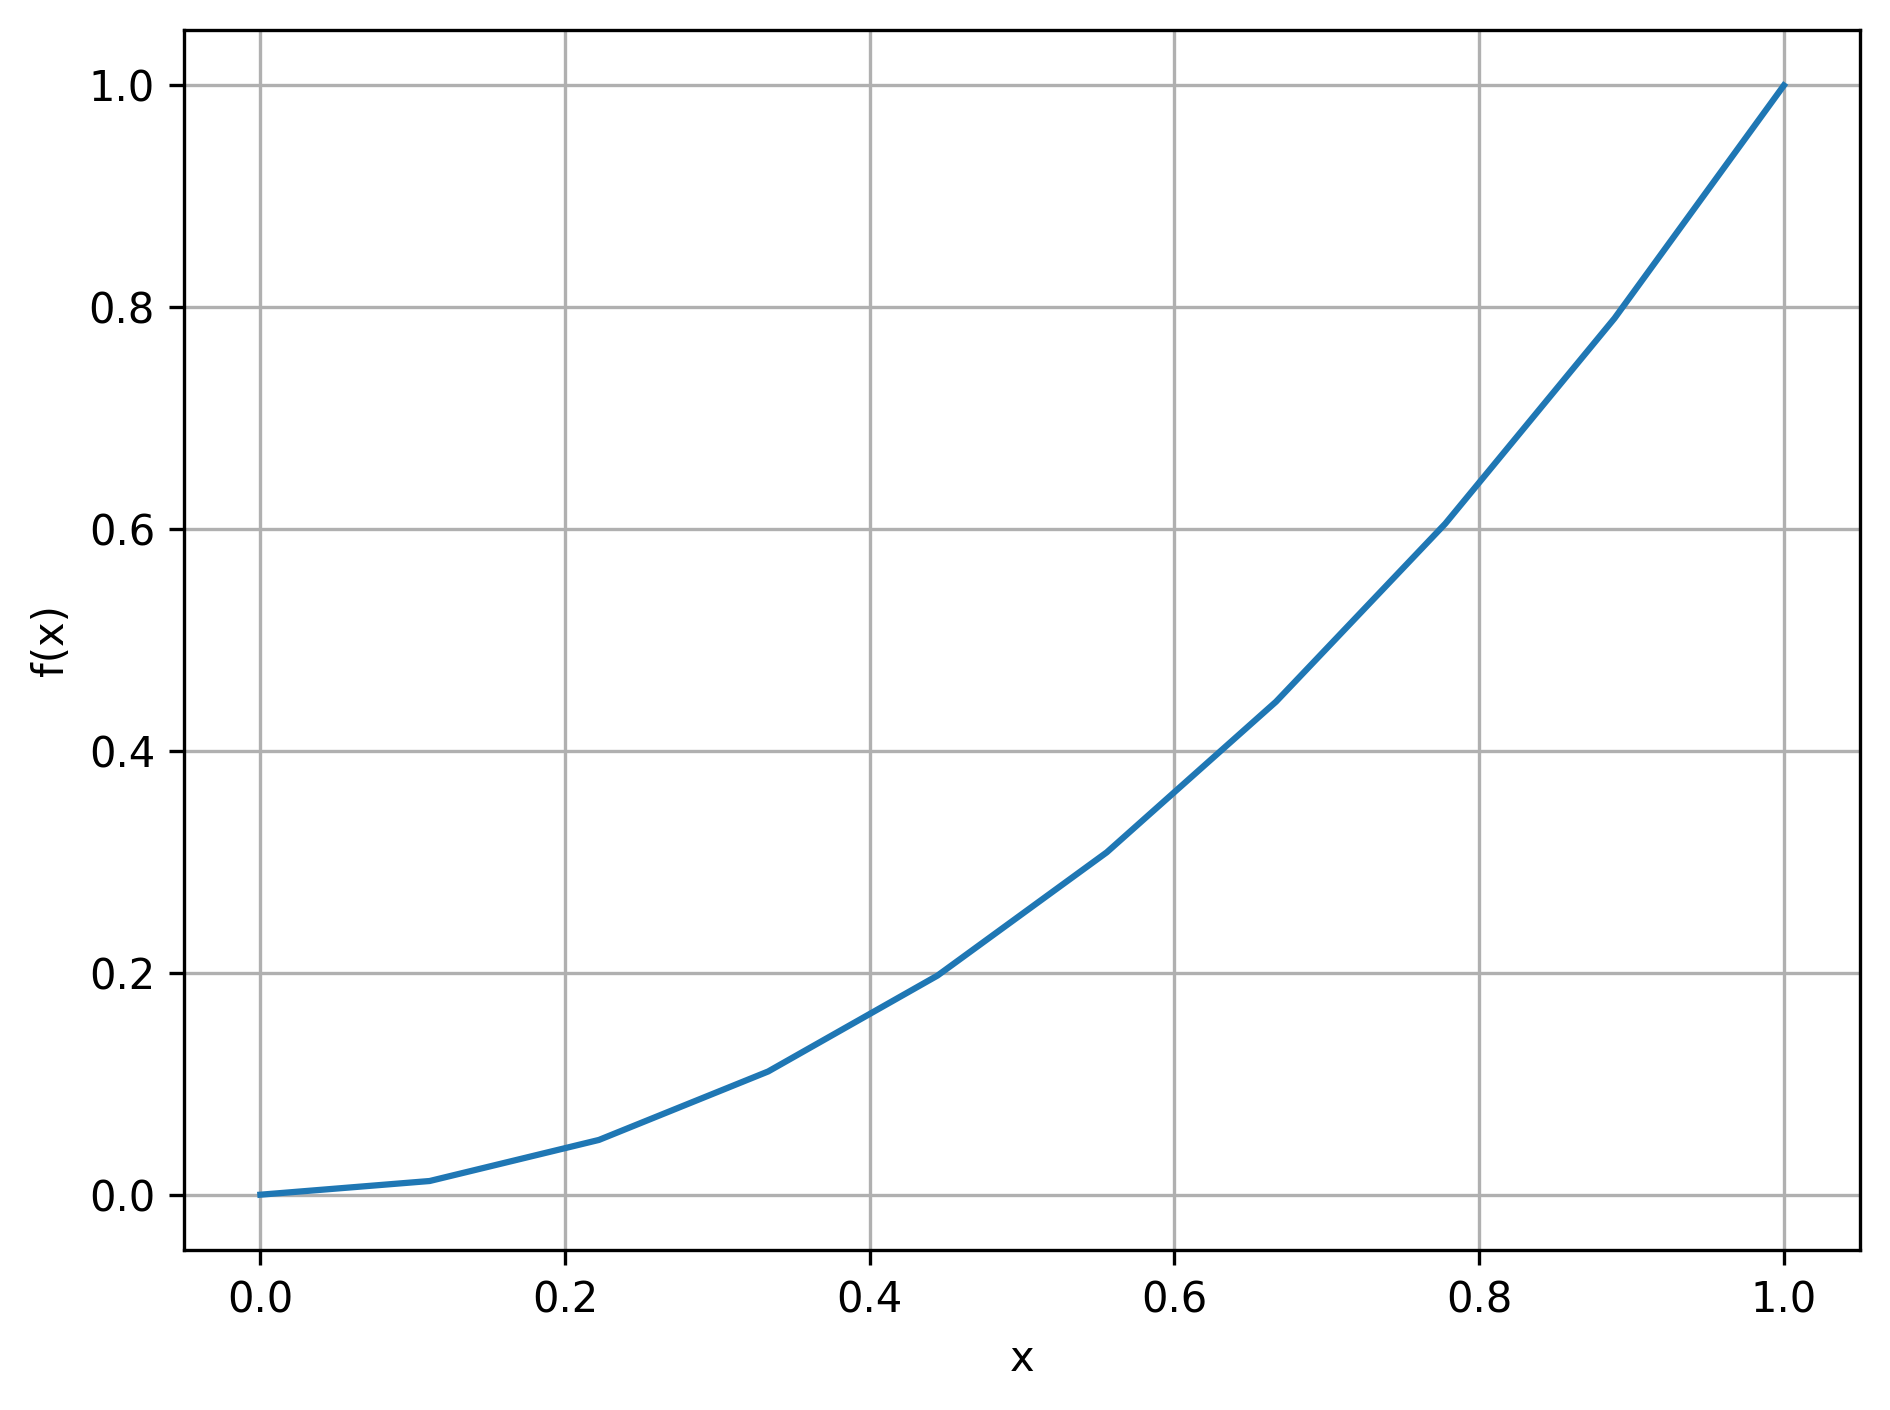

In [20]:
x = np.linspace(0, 1, 10)
f = x**2

plt.plot(x, f)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.tight_layout()
plt.show()

We do not need to know the functional form of $f(x)$ to take the numerical derivatives—this example just uses a simple function for ease of checking the results.

The `gradient()` function uses second-order central differences to evaluate the derivative of input data, using forward and backward differences at the boundaries. Let's use that to get the derivative, and compare against the exact derivative ($\frac{df}{dx} = 2x$):

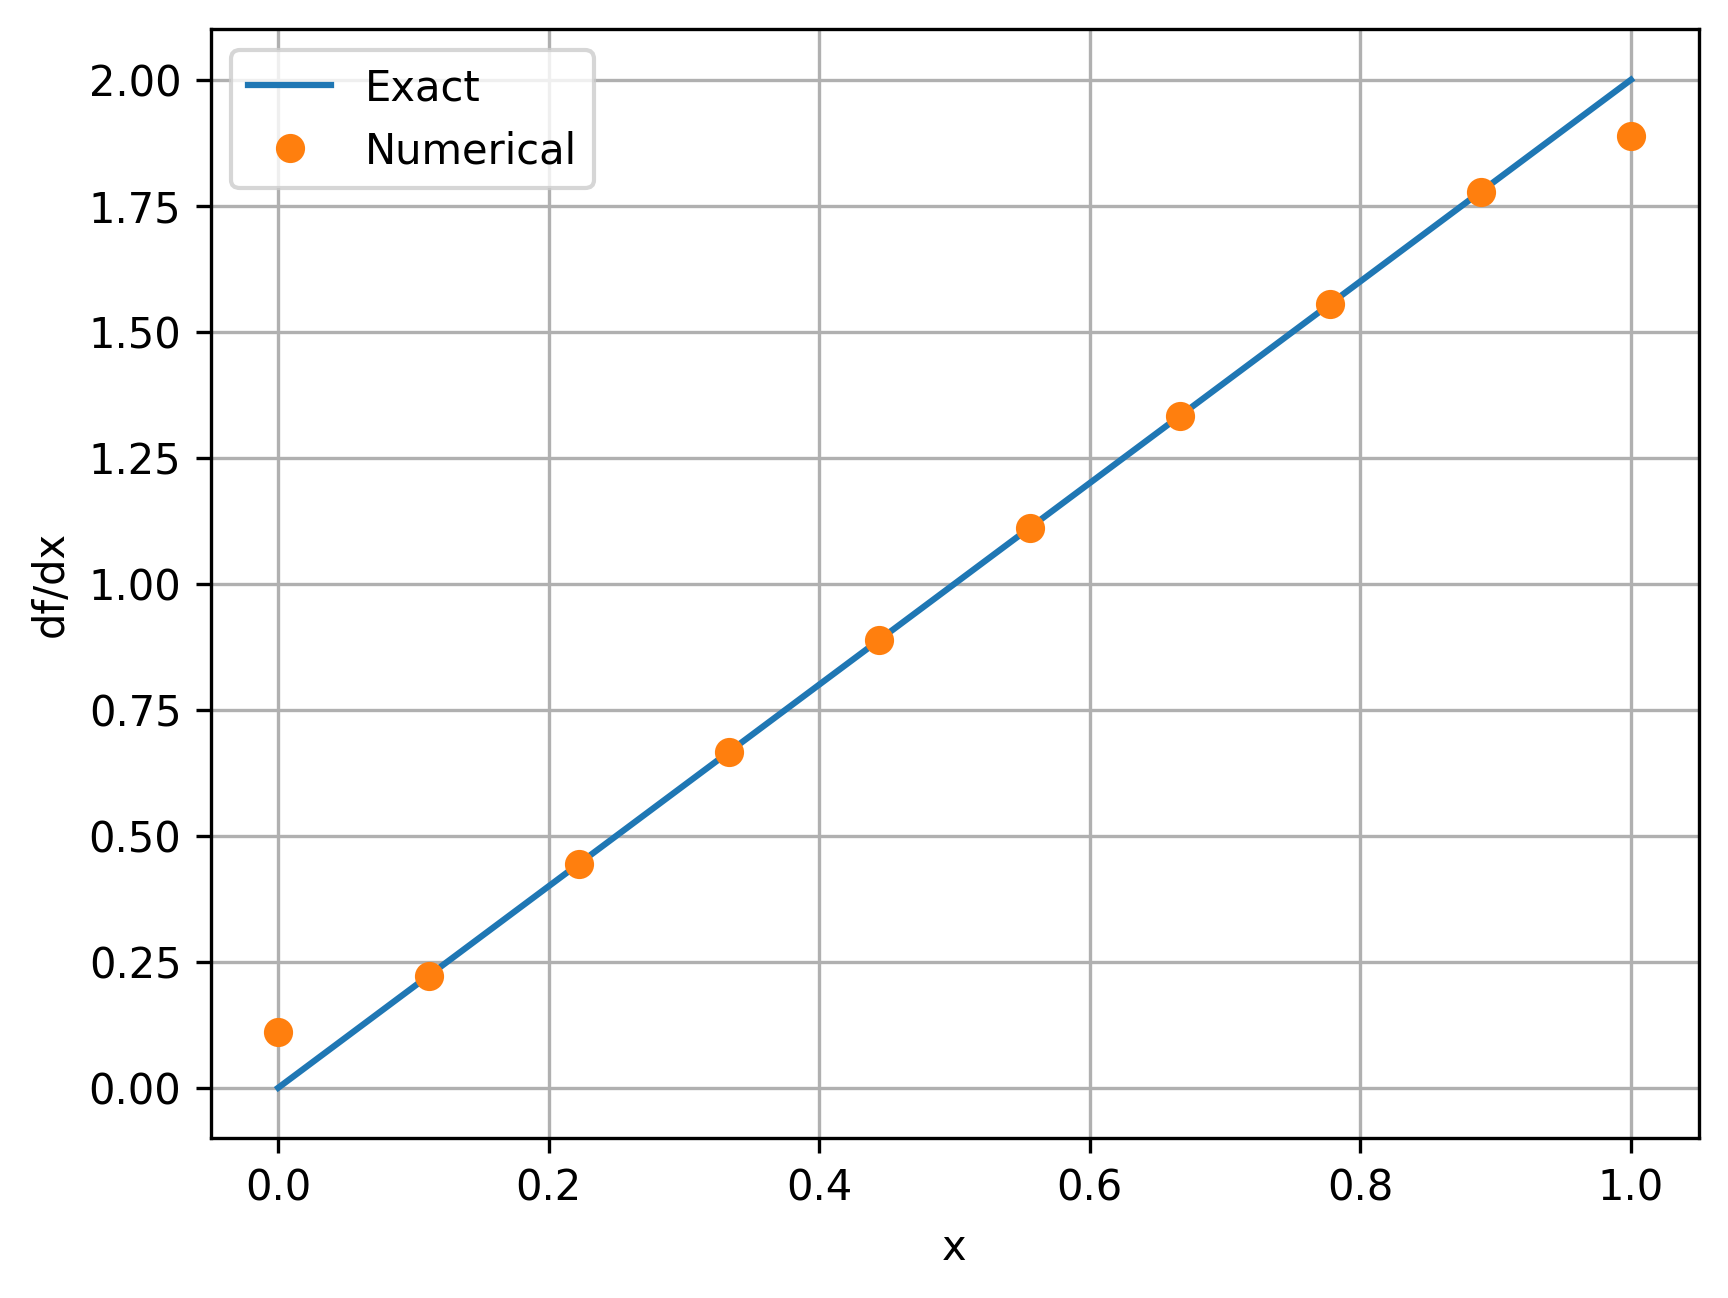

In [21]:
dfdx = np.gradient(f, x)
dfdx_exact = 2*x

plt.plot(x, dfdx_exact, label='Exact')
plt.plot(x, dfdx, 'o', label='Numerical')
plt.xlabel('x')
plt.ylabel('df/dx')

plt.grid(True)
plt.legend()
plt.show()

The numerical derivative we obtain is very accurate, thanks to the linear nature of the derivative. However, at the boundaries the approximate derivative is a bit off, due to the first-order finite differences used there.

### Analytical derivative

In some cases we may be given (or obtain) analytical expressions that we need to differentiate. Given a function, we have two options for calculating the derivative:

1. Use the function to calculate values over the desired range, then numerically differentiate.
2. Obtain the exact derivative by differentiating analytically.

We'll now focus on the latter case; we can use SymPy to construct a function symbolically, and then find the exact derivative.

In [22]:
import sympy
sympy.init_printing(use_latex='mathjax')

x = sympy.symbols('x', real=True)

f = x**2

# take derivative of f with respect to x
dfdx = sympy.diff(f, x)

# this complicated expression is only necessary for printing.
# It creates an equation object, that sets the unevaluated 
# derivative of f equal to the calculated derivative.
display(sympy.Eq(sympy.Derivative(f), dfdx))

d ⎛ 2⎞      
──⎝x ⎠ = 2⋅x
dx          

Once we have evaluated the analytical derivative, we can even turn it into a Python function for evaluation! Passing the `'numpy'` argument creates a NumPy array-compatible function.

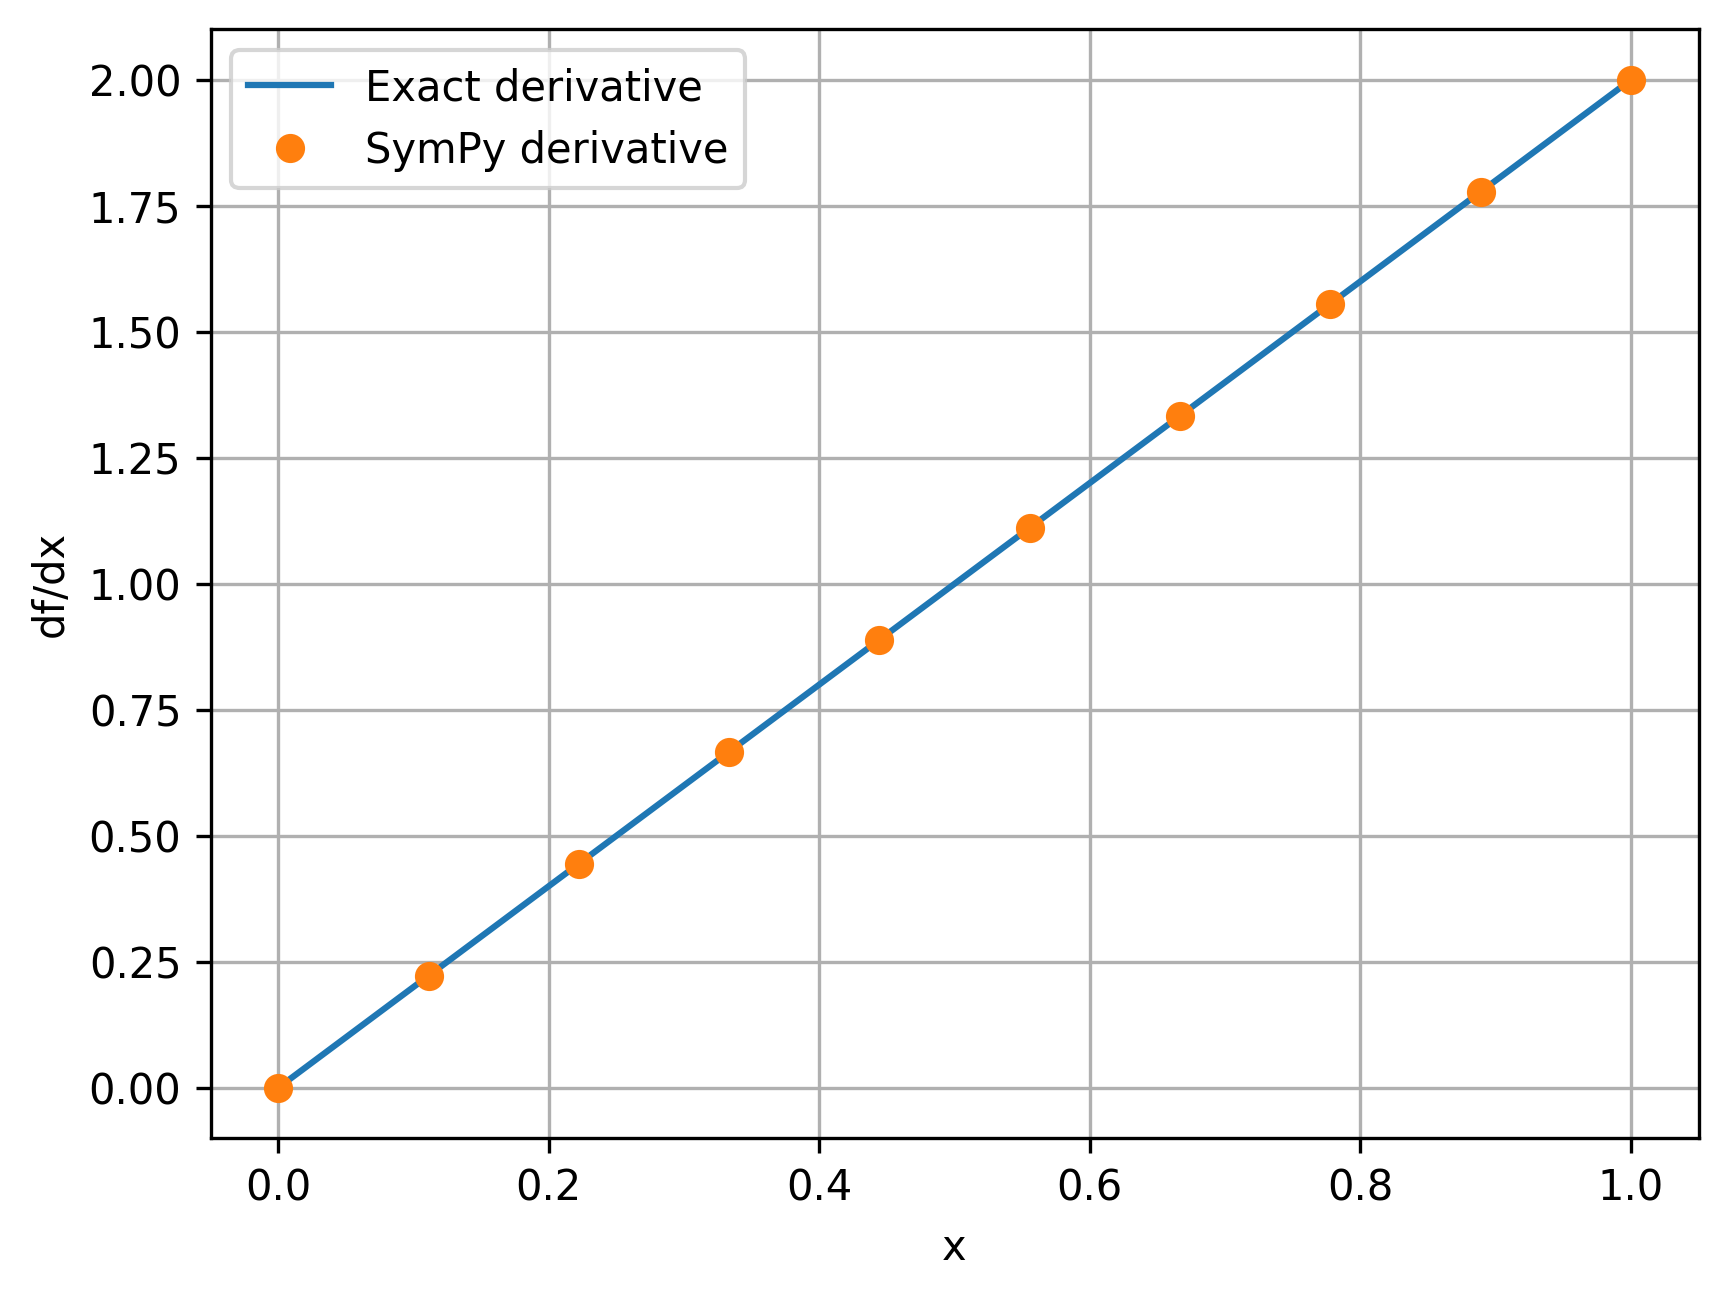

In [23]:
calc_derivative = sympy.lambdify(x, dfdx, 'numpy')

x_vals = np.linspace(0, 1, 10)

plt.plot(x_vals, 2*x_vals, label='Exact derivative')
plt.plot(x_vals, calc_derivative(x_vals), 'o', label='SymPy derivative')

plt.xlabel('x')
plt.ylabel('df/dx')
plt.grid(True)
plt.legend()
plt.show()

As expected, the exact derivative we calculated using SymPy matches the known derivative perfectly—this was obtained symbolically, so there are no approximations/errors involved.

When taking the derivative of more complicated expressions that involve other functions (e.g., $\sin$, $\log$), you will need to use the SymPy-provided versions: `sympy.sin`, `sympy.log`, etc. We also need to explicitly define symbolic variables, either using `x = sympy.Symbol('x')` to create one variable at a time or `x, y = sympy.symbols('x y', real=True)` to create multiple variables at once. (The string you specify is the displayed representation of the variable, and can include complex formatting such as subscripts/superscripts and Greek letters.)

For example, let's take the derivative of
$$
f(x) = \log(x) + x^3
$$

In [24]:
x = sympy.Symbol('x')
f = sympy.log(x) + x**3

dfdx = sympy.diff(f, x)

display(dfdx)

   2   1
3⋅x  + ─
       x

This matches what we expect for this derivative.